In [1]:
import rdkit # compchem library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole # use this to draw molecules in the notebook
print(rdkit.__version__)

import pandas as pd
import numpy as np

2025.09.3


Data for this exercise taken from the [DUD-E validation dataset](http://dude.docking.org/targets/try1).

In [2]:
def get_mols(smi_file):
    mols = []
    with open(smi_file) as f:
        for l in f:
            mols.append(l.split()[0])
    return mols

In [3]:
n = 200
actives = [ Chem.MolFromSmiles(m) for m in get_mols('./data/hivpr_actives_final.ism')[:n] ]
decoys = [ Chem.MolFromSmiles(m) for m in get_mols('./data/hivpr_decoys_final.ism')[:n] ]

query = actives[0]

df = pd.DataFrame()
df['molecule'] = actives[1:] + decoys
actual_class = ([1] * (len(actives)-1)) + ([0] * len(decoys))
df['class'] = actual_class
df

,molecule,class
0,<rdkit.Chem.rdchem.Mol object at 0x76d9ecc73a00>,1
1,<rdkit.Chem.rdchem.Mol object at 0x76d9ecc73a70>,1
2,<rdkit.Chem.rdchem.Mol object at 0x76d9ecc73ae0>,1
3,<rdkit.Chem.rdchem.Mol object at 0x76d9ecc73b50>,1
4,<rdkit.Chem.rdchem.Mol object at 0x76d9ecc73bc0>,1
...,...,...
394,<rdkit.Chem.rdchem.Mol object at 0x76d9eccaace0>,0
395,<rdkit.Chem.rdchem.Mol object at 0x76d9eccaad50>,0
396,<rdkit.Chem.rdchem.Mol object at 0x76d9eccaadc0>,0
397,<rdkit.Chem.rdchem.Mol object at 0x76d9eccaae30>,0


In [4]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs

def get_fp(mol, generator):
    return generator.GetFingerprint(mol)

def sim(fp1, fp2):
    return DataStructs.DiceSimilarity(fp1, fp2)

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
query_fp = get_fp(query, morgan_gen)

df['fp'] = df['molecule'].apply(lambda x: get_fp(x, morgan_gen)) 
df['sim_score'] = df['fp'].apply(lambda x: sim(x, query_fp)) 
df2 = df.sort_values('sim_score', ascending=False)
df2
# df.to_csv('fp_similarity.csv', sep='\t')

,molecule,class,fp,sim_score
181,<rdkit.Chem.rdchem.Mol object at 0x76d9eccb0a50>,1,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.885714
2,<rdkit.Chem.rdchem.Mol object at 0x76d9ecc73ae0>,1,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.794326
0,<rdkit.Chem.rdchem.Mol object at 0x76d9ecc73a00>,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.779412
3,<rdkit.Chem.rdchem.Mol object at 0x76d9ecc73b50>,1,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.774648
176,<rdkit.Chem.rdchem.Mol object at 0x76d9eccb0820>,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.726027
...,...,...,...,...
342,<rdkit.Chem.rdchem.Mol object at 0x76d9ecca9620>,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.142857
341,<rdkit.Chem.rdchem.Mol object at 0x76d9ecca95b0>,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.137931
387,<rdkit.Chem.rdchem.Mol object at 0x76d9eccaa9d0>,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.134454
310,<rdkit.Chem.rdchem.Mol object at 0x76d9ecca8820>,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.128000


In [5]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(df2['class'], df2['sim_score'])
auc = metrics.roc_auc_score(df2['class'], df2['sim_score'])

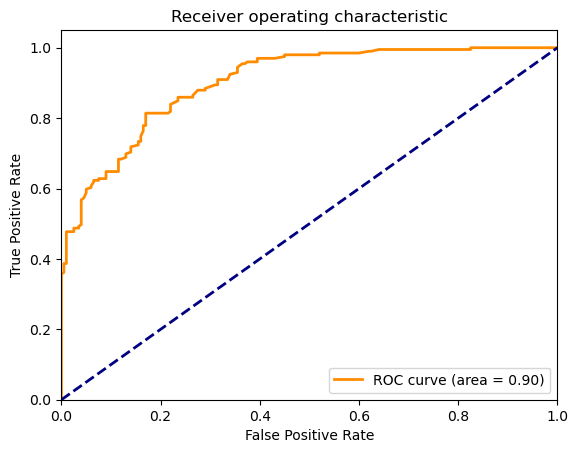

In [6]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Practical Tasks

* Can you build an ML model which out performs this unsophisticated search?
* How would you compare performance between the two models?